In [1]:
%load_ext jupyter_black

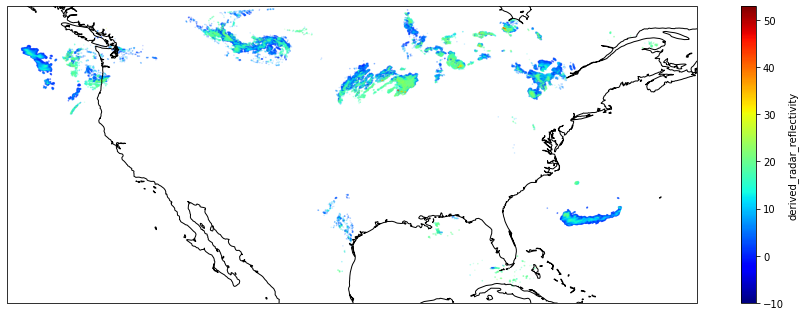

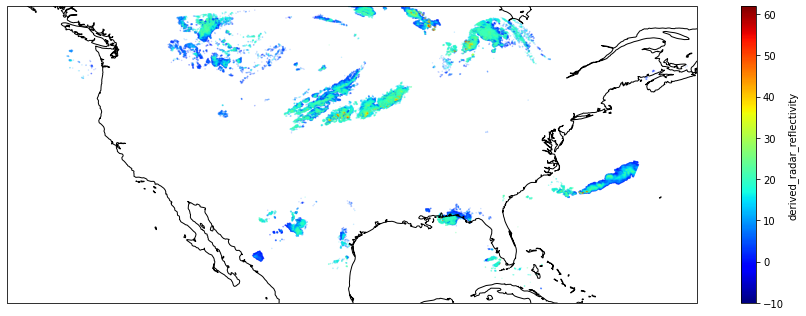

<Figure size 432x288 with 0 Axes>

In [9]:
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr

from griblib.hrrr import HRRR


def open_gribs(files: list[str]) -> HRRR:
    return HRRR(files if isinstance(files, list) else [files])


def scatter_plot(ds: xr.Dataset, parameter: str, **kwargs):
    columns = {
        v.attrs["GRIB_shortName"]: v.attrs["long_name"].lower().replace(" ", "_") for v in ds.data_vars.values()
    }
    for vt, df in ds.to_dataframe().rename(columns=columns).groupby("valid_time"):
        plt.rcParams["axes.grid"] = True
        ax = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree())
        plt.figure(vt.value)

        ax.coastlines("50m")

        ax.set_extent(
            [
                *df["longitude"].agg(["min", "max"]),
                *df["latitude"].agg(["min", "max"]),
            ],
            ccrs.PlateCarree(),
        )

        df.plot(
            kind="scatter",
            y="latitude",
            x="longitude",
            c=parameter,
            ax=ax,
            alpha=np.where(df[parameter] > 0, 0.2, 0),
            cmap=plt.get_cmap("jet"),
            s=0.25,
            figsize=(16, 12),
            **kwargs,
        )


if __name__ == "__main__":
    hrrr = open_gribs(glob("data/hrrr/*.grib2")[:2])
    hrrr.derived_radar_reflectivity().pipe(scatter_plot, parameter="derived_radar_reflectivity")